<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

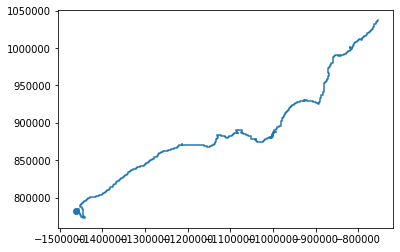

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shapefile

outputfile = 'Contour.geo'
el_size = 1000
spline = False
gmsh3 = False

#first shp for the first boundary
sf = shapefile.Reader('ronnie_sea.shp')
shelf = np.array(sf.shape(0).points)
shelf = shelf[:-1, :]
shelf = shelf[::-1, :]

plt.figure()
plt.plot(shelf[:, 0], shelf[:, 1])
plt.scatter(shelf[0, 0], shelf[0, 1])

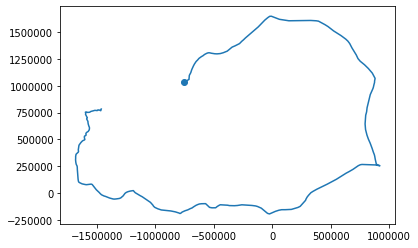

In [2]:
#second shp for the second boundary
sf = shapefile.Reader('ronnie_ground.shp')
ground = np.array(sf.shape(0).points)
ground = ground[1:, :]

plt.figure()
plt.plot(ground[:, 0], ground[:, 1])
plt.scatter(ground[0, 0], ground[0, 1])

In [3]:
#merge of the contour
mesh = np.concatenate((shelf,ground), axis=0)#if there is more boundary add them as np.concatenate((bd1,bd2,bd3),axis=0)
lim=[len(shelf)]#if there is more boundary add them as [len(bd1),len(bd2),len(bd3)]


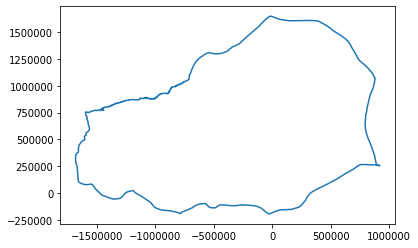

In [4]:
#check if it seem right
plt.figure()
plt.plot(mesh[:, 0], mesh[:, 1])

In [12]:
mesh[:,1].min()

-194344.40573864247

In [5]:
#make geo file
x = mesh[:, 0]
y = mesh[:, 1]


if x[0] == x[-1] and y[0] == y[-1]:
    #print('Same first and last points in contour file')
    Npt = len(x)-1
else:
    Npt = len(x)

print('found %i points' % Npt)

# Open the output file
geo = open(outputfile, 'w')
geo.write('// This a a geo file created using the python script Makegeo.py // \n')
geo.write('Mesh.Algorithm=5; \n')
geo.write('// To controle the element size, one can directly modify the lc value in the geo file // \n')
geo.write('lc = {0} ; \n'.format(el_size))

# write the points coordinates (x,y,0,lc)
np = 0
for j in range(0, Npt):
    np = np+1
    geo.write('Point({0}) = '.format(np) +
              r'{'+' {0}, {1}, 0.0, lc'.format(x[j], y[j])+r'}'+'; \n')

# if spline
if spline:
    geo.write('Spline(1) = {')
    for j in range(0, Npt):
        geo.write('{0},'.format(j+1))
    geo.write('1}; \n')

    geo.write('Line Loop(2) = {1}; \n')
    geo.write('Plane Surface(3) = {2}; \n')
    geo.write('Physical Line(4) = {1}; \n')
    geo.write('Physical Surface(5) = {3}; \n')
# else it is lines, as a spline might not work in all case
else:
    nl = 0
    for j in range(0, Npt-1):
        nl = nl+1
        geo.write('Line({0}) = '.format(nl) +
                  r'{'+'{0},{1}'.format(j+1, j+2)+r'}'+'; \n')
    geo.write('Line({0}) = '.format(nl+1) +
              r'{'+'{0},{1}'.format(j+2, 1)+r'}'+'; \n')

    # olg gmsh3 using Compound Line
    if gmsh3:
        geo.write('Compound Line({0}) = '.format(nl+2)+r'{')
        for j in range(0, Npt-1):
            geo.write('{0}, '.format(j+1))
        geo.write('{0}'.format(j+2)+'}; \n')

        geo.write('Line Loop({0}) = '.format(nl+3) +
                  r'{'+'{0}'.format(nl+2)+r'};'+' \n')
        geo.write('Plane Surface({0}) = '.format(
            nl+4)+r'{'+'{0}'.format(nl+3)+r'};'+' \n')
        geo.write('Physical Line({0}) = '.format(
            nl+5)+r'{'+'{0}'.format(nl+2)+r'};'+' \n')
        geo.write('Physical Surface({0}) = '.format(
            nl+6)+r'{'+'{0}'.format(nl+4)+r'};'+' \n')

    else:
        geo.write('Curve Loop({0}) = '.format(nl+2) +
                  r'{'+'{0}:{1}'.format(1, nl+1)+r'};'+' \n')
        geo.write('Plane Surface({0}) = '.format(
            nl+3)+r'{'+'{0}'.format(nl+2)+r'};'+' \n')
        for i in range(1,len(lim)+1):
            geo.write('Physical Curve({0}) = '.format(
                nl+3+i)+r'{'+'{0}:{1}'.format(1, lim[i-1])+r'};'+' \n')
        geo.write('Physical Curve({0}) = '.format(
                nl+4+i)+r'{'+'{0}:{1}'.format(lim[-1], nl+1)+r'};'+' \n')
        geo.write('Physical Surface({0}) = '.format(
            nl+5+i)+r'{'+'{0}'.format(nl+3)+r'};'+' \n')

geo.close()

found 1308 points
